<a href="https://colab.research.google.com/github/MahfujaJarin/Predicting-Price-Hike-with-Sources-using-Different-Machine-Learning-Algorithms/blob/main/SVR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

SVR

Mean Squared Error: 3280.063483638078
R^2 Score: 0.9650330057165724
Precision: 0.9393063583815029
Recall: 0.9259259259259259
Accuracy: 0.9351724137931035
F1 Score: 0.9325681492109039


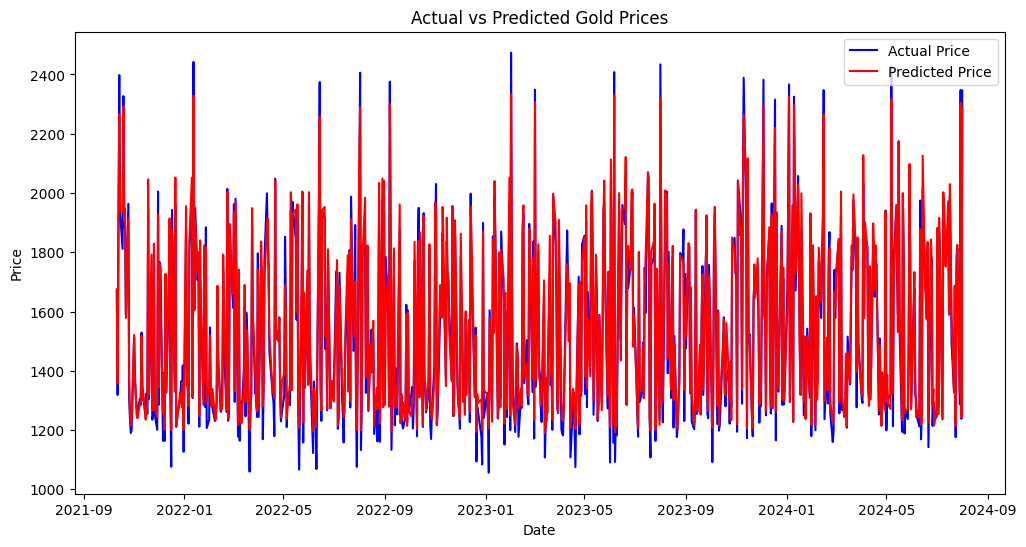

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, r2_score, precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
# Load the dataset
file_path = '/content/Gold Futures Historical Data (2).csv'
data = pd.read_csv(file_path)

# Data Preprocessing
def convert_volume(value):
    if isinstance(value, str):
        if 'K' in value:
            return float(value.replace('K', '')) * 1000
        elif 'M' in value:
            return float(value.replace('M', '')) * 1000000
        else:
            return float(value.replace(',', ''))
    return value  # If it's already a float

# Apply the conversion function to the 'Vol.' column
data['Vol.'] = data['Vol.'].apply(convert_volume)

# Convert 'Date' column to datetime
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

# Convert other columns to numeric
for col in ['Price', 'Open', 'High', 'Low']:
    data[col] = data[col].astype(str).str.replace(',', '', regex=False)
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Handle the 'Change %' column
data['Change %'] = data['Change %'].astype(str).str.strip().str.replace('%', '', regex=False)
data['Change %'] = pd.to_numeric(data['Change %'], errors='coerce')

# Check and handle missing values for each column
for col in data.columns:
    if data[col].isnull().sum() > 0:
        if col == 'Vol.':  # Fill 'Vol.' with median
            data[col].fillna(data[col].median(), inplace=True)
        elif col in ['Price', 'Open', 'High', 'Low']:  # Numeric columns with iterative imputation
            imputer = IterativeImputer()
            data[[col]] = imputer.fit_transform(data[[col]])
        elif col == 'Change %':  # Choose an appropriate fill strategy for 'Change %'
            data[col].fillna(data[col].mean(), inplace=True)  # Here using mean as an example
        else:
            data.dropna(subset=[col], inplace=True)  # Drop rows with missing data in non-essential columns

# Drop rows with any remaining missing values (e.g., in 'Date' or other non-numeric columns)
data.dropna(inplace=True)

# Sort by date
data.sort_values(by='Date', inplace=True)

# Feature Scaling
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[['Price', 'Open', 'High', 'Low', 'Vol.']])

# Create sequences for SVR model
X = []
y = []

window_size = 90

for i in range(window_size, len(scaled_data)):
    X.append(scaled_data[i-window_size:i].flatten())  # Flatten the sequence to a vector
    y.append(scaled_data[i, 0])  # Predicting 'Price' column

X = np.array(X)
y = np.array(y)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build and train the SVR model
model = SVR(kernel='rbf')  # You can experiment with different kernels
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Reverse the scaling for better interpretability
y_test_actual = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((len(y_test), 4))), axis=1))[:, 0]
y_pred_actual = scaler.inverse_transform(np.concatenate((y_pred.reshape(-1, 1), np.zeros((len(y_pred), 4))), axis=1))[:, 0]

# Calculate performance metrics
mse = mean_squared_error(y_test_actual, y_pred_actual)
r2 = r2_score(y_test_actual, y_pred_actual)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Convert regression output to classification for metrics
# Assume price increases by more than a threshold are considered positive
threshold = 0.01  # Example threshold
y_test_binary = (np.diff(y_test_actual) > threshold).astype(int)
y_pred_binary = (np.diff(y_pred_actual) > threshold).astype(int)

# Calculate classification metrics
precision = precision_score(y_test_binary, y_pred_binary)
recall = recall_score(y_test_binary, y_pred_binary)
accuracy = accuracy_score(y_test_binary, y_pred_binary)
f1 = f1_score(y_test_binary, y_pred_binary)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")

# Plot Actual vs Predicted values
plt.figure(figsize=(12, 6))
plt.plot(data['Date'][-len(y_test_actual):], y_test_actual, color='blue', label='Actual Price')
plt.plot(data['Date'][-len(y_pred_actual):], y_pred_actual, color='red', label='Predicted Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Predicted Gold Prices')
plt.legend()
plt.show()


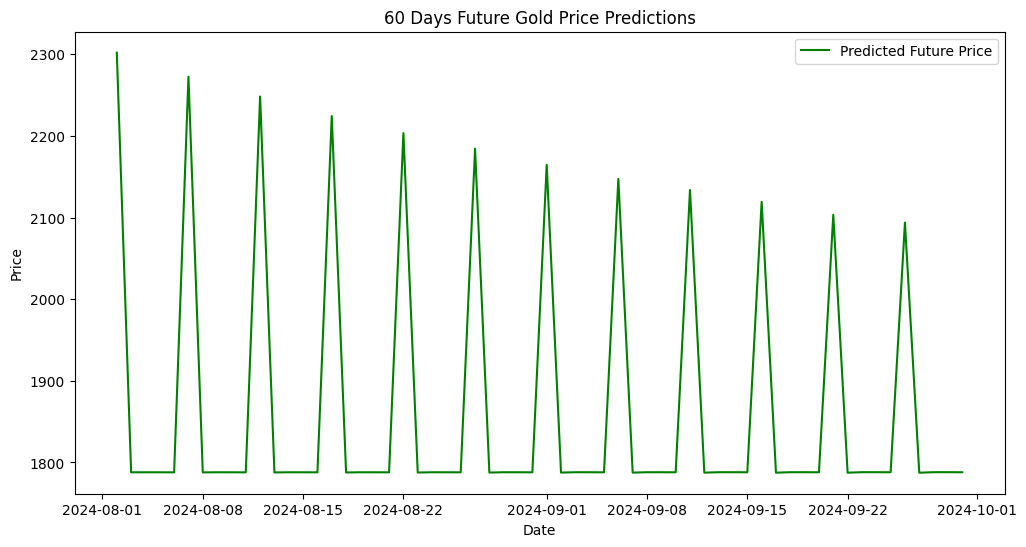

In [ ]:
# Prepare the last sequence from the training data for future prediction
last_sequence = scaled_data[-window_size:].flatten()

# List to store predictions
future_predictions = []

# Predicting the next 60 days
for _ in range(60):
    # Reshape the last sequence for prediction
    next_input = last_sequence.reshape(1, -1)

    # Predict the next value
    next_prediction = model.predict(next_input)

    # Append the predicted value to the future predictions list
    future_predictions.append(next_prediction[0])

    # Update the sequence to include the new prediction
    last_sequence = np.append(last_sequence[1:], next_prediction)

# Reverse the scaling for better interpretability
future_predictions_actual = scaler.inverse_transform(np.concatenate((np.array(future_predictions).reshape(-1, 1), np.zeros((60, 4))), axis=1))[:, 0]

# Generate future dates
future_dates = pd.date_range(start=data['Date'].iloc[-1] + pd.Timedelta(days=1), periods=60)

# Plot the future predictions
plt.figure(figsize=(12, 6))
plt.plot(future_dates, future_predictions_actual, color='green', label='Predicted Future Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('60 Days Future Gold Price Predictions')
plt.legend()
plt.show()


Mean Squared Error: 3187.9431983088502
R^2 Score: 0.9667486812202011
Precision: 0.9252873563218391
Recall: 0.92
Accuracy: 0.9255172413793104
F1 Score: 0.9226361031518626


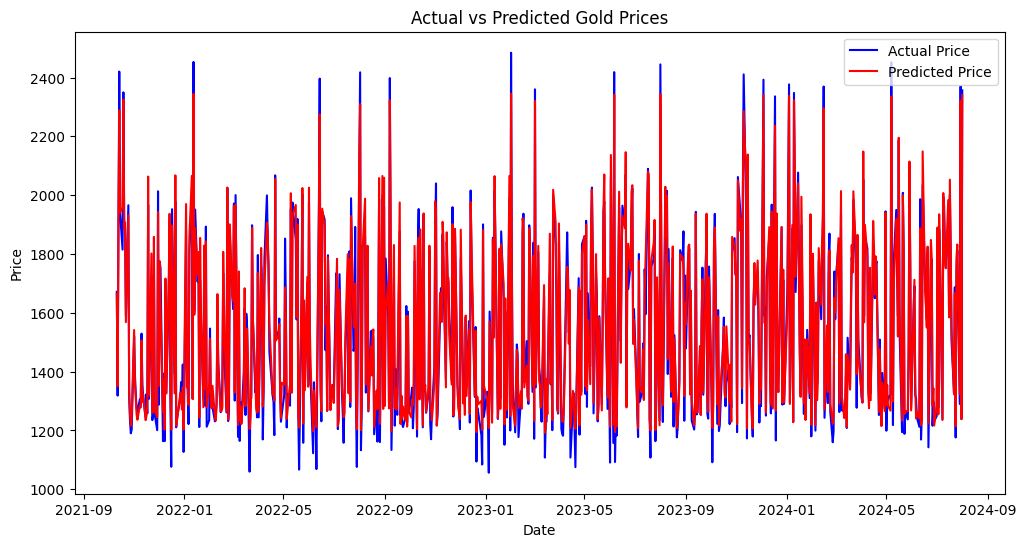

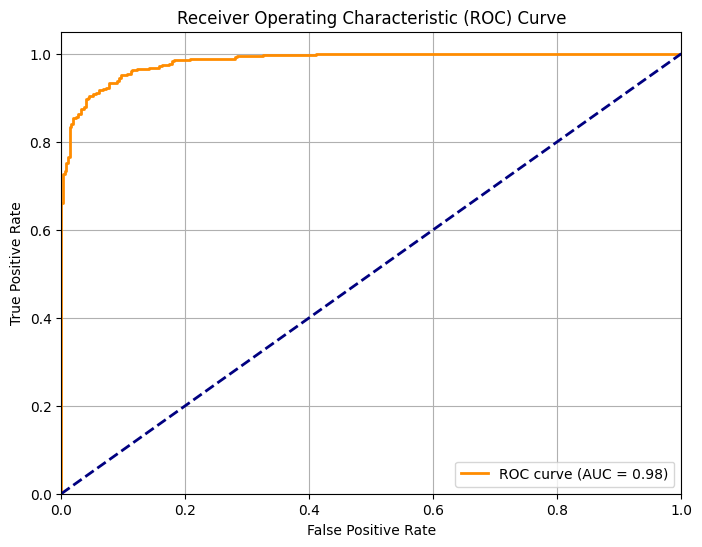

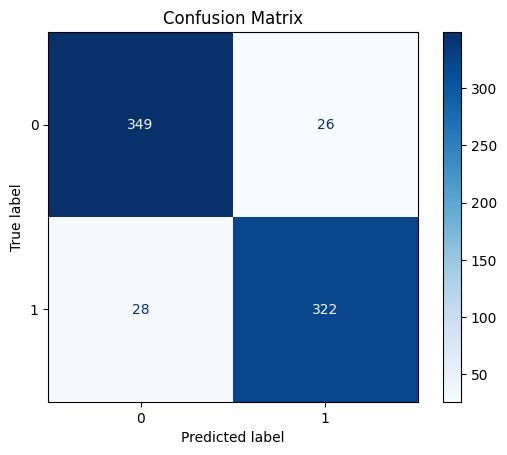

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, precision_score, recall_score, f1_score, accuracy_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# Load the dataset
file_path = '/content/Gold Futures Historical Data.csv'
data = pd.read_csv(file_path)

# Data Preprocessing
def convert_volume(value):
    if isinstance(value, str):
        if 'K' in value:
            return float(value.replace('K', '')) * 1000
        elif 'M' in value:
            return float(value.replace('M', '')) * 1000000
        else:
            return float(value.replace(',', ''))
    return value  # If it's already a float

# Apply the conversion function to the 'Vol.' column
data['Vol.'] = data['Vol.'].apply(convert_volume)

# Convert 'Date' column to datetime
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

# Convert other columns to numeric
for col in ['Price', 'Open', 'High', 'Low']:
    data[col] = data[col].astype(str).str.replace(',', '', regex=False)
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Handle the 'Change %' column
data['Change %'] = data['Change %'].astype(str).str.strip().str.replace('%', '', regex=False)
data['Change %'] = pd.to_numeric(data['Change %'], errors='coerce')

# Handle missing values in 'Vol.' column
data['Vol.'].fillna(0, inplace=True)

# Drop rows with any remaining missing values
data.dropna(inplace=True)

# Sort by date
data.sort_values(by='Date', inplace=True)

# Feature Scaling
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[['Price', 'Open', 'High', 'Low', 'Vol.']])

# Create sequences for SVR model
X = []
y = []

window_size = 90

for i in range(window_size, len(scaled_data)):
    X.append(scaled_data[i-window_size:i].flatten())  # Flatten the sequence to a vector
    y.append(scaled_data[i, 0])  # Predicting 'Price' column

X = np.array(X)
y = np.array(y)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build and train the SVR model
model = SVR(kernel='rbf')  # You can experiment with different kernels
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Reverse the scaling for better interpretability
y_test_actual = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((len(y_test), 4))), axis=1))[:, 0]
y_pred_actual = scaler.inverse_transform(np.concatenate((y_pred.reshape(-1, 1), np.zeros((len(y_pred), 4))), axis=1))[:, 0]

# Calculate performance metrics
mse = mean_squared_error(y_test_actual, y_pred_actual)
r2 = r2_score(y_test_actual, y_pred_actual)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Convert regression output to binary classification for metrics
threshold = 0.01  # Example threshold for change detection
y_test_binary = (np.diff(y_test_actual) > threshold).astype(int)
y_pred_binary = (np.diff(y_pred_actual) > threshold).astype(int)

# Calculate classification metrics
precision = precision_score(y_test_binary, y_pred_binary)
recall = recall_score(y_test_binary, y_pred_binary)
accuracy = accuracy_score(y_test_binary, y_pred_binary)
f1 = f1_score(y_test_binary, y_pred_binary)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")

# Plot Actual vs Predicted values
plt.figure(figsize=(12, 6))
plt.plot(data['Date'][-len(y_test_actual):], y_test_actual, color='blue', label='Actual Price')
plt.plot(data['Date'][-len(y_pred_actual):], y_pred_actual, color='red', label='Predicted Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Predicted Gold Prices')
plt.legend()
plt.show()

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test_binary, np.diff(y_pred_actual))
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Plot Confusion Matrix
cm = confusion_matrix(y_test_binary, y_pred_binary)
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()


In [ ]:
import joblib

# Save the trained SVR model to a file
model_save_path = '/mnt/data/svr_model.pkl'
joblib.dump(model, model_save_path)

model_save_path